In [4]:
import pandas as pd
import matplotlib.pyplot as plt

In [5]:
line = " " 
with open("results.csv", 'r') as f:
    with open("results-new.csv", 'w') as fout:
        while line != None:
            # try:
            line = f.readline()
            if line[0:6] == "client":
                fout.write(line)
            # except Exception as e:
            #     f.seek()


KeyboardInterrupt: 

In [6]:
df = pd.read_csv("results-new.csv", header=None, delimiter=' ', )
df

,0,1,2
0,client1,1701465886,26716
1,client1,1701465887,26668
2,client1,1701465888,26652
3,client1,1701465889,27184
4,client1,1701465890,26712
...,...,...,...
356521,client2,1701584738,31556
356522,client3,1701584738,31560
356523,client1,1701584739,31550
356524,client2,1701584739,31559


In [7]:
df['client'] = df[0]
df['sec'] = df[1]
df['ms'] = df[2]
df.drop(columns=[0,1,2], inplace=True)

In [8]:
df1 = df[df['client'] == "client1"]
df2 = df[df['client'] == "client2"]
df3 = df[df['client'] == "client3"]

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


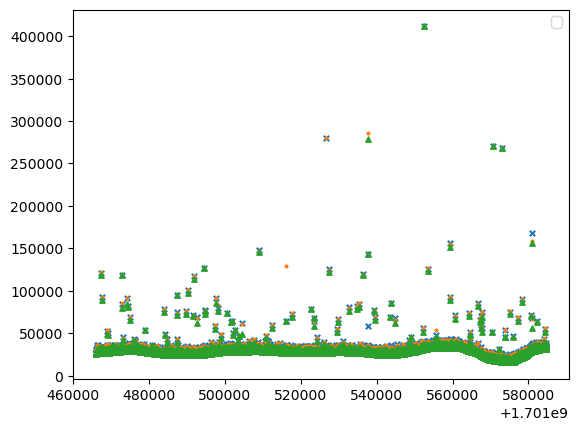

In [14]:
plt.scatter(df1["sec"], df1["ms"], s=15, marker='x')
plt.scatter(df2["sec"], df2["ms"], s=15, marker='.')
plt.scatter(df3["sec"], df3["ms"], s=15, marker='^')
plt.legend()

In [ ]:
df[df['ms'] > 100000] 

,0,1,2,client,sec,ms
4281,client3,1701467317,118178,client3,1701467317,118178
4282,client1,1701467317,121530,client1,1701467317,121530
4283,client2,1701467317,122034,client2,1701467317,122034
21111,client1,1701472927,119092,client1,1701472927,119092
21112,client2,1701472927,119101,client2,1701472927,119101
21113,client3,1701472927,119105,client3,1701472927,119105
73489,client1,1701490386,100816,client1,1701490386,100816
73490,client2,1701490386,101290,client2,1701490386,101290
77712,client3,1701491794,113735,client3,1701491794,113735
77713,client1,1701491794,117207,client1,1701491794,117207
